In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
#sys.path.insert(0, '/Users/ammar.tareen/Desktop/Research_projects/mavenn2/')
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
# # Load example data
# data_df = mavenn.load_example_dataset('sortseq')

# # Separate test from data_df
# ix_test = data_df['set']=='test'
# test_df = data_df[ix_test].reset_index(drop=True)
# print(f'test N: {len(test_df):,}')

# # Remove test data from data_df
# data_df = data_df[~ix_test].reset_index(drop=True)
# print(f'training + validation N: {len(data_df):,}')
# data_df.head()
#pd.read_csv
data_df_full = pd.read_csv('../data/2022.05.15.ace2rbd/ace2rbd_raw_counts_lib1.csv')
data_df = data_df_full[['x','SortSeq_bin1','SortSeq_bin2','SortSeq_bin3','SortSeq_bin4']].copy()
data_df.head(10)

,x,SortSeq_bin1,SortSeq_bin2,SortSeq_bin3,SortSeq_bin4
0,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,0
1,NITNLCPFGEVFSATRFASVYAWNRKRISNCVADYSVLYNSASFST...,116,92,21,3
2,NITNLCPFGEVFNATRFASVYCWNRKRISNCVADYSVLYNSASFST...,158,120,137,15
3,NITNLCPFGEVFFATRFASVYAWNRKRISNCVADYSVLYNSASFST...,47,234,521,116
4,NITNLKPFGEVFNAWRFASVYAWNRKRISNCVADYSVLYNSASFST...,299,32,1,1
5,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,322,238,196,14
6,NITNLCPFGEVFNATRFVSVYAWNRKRISNCVADYSVLYNSASFST...,38,78,181,45
7,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,1364,24,43,15
8,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,64,129,122,27
9,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,6,22


In [3]:
y_cols = data_df.columns[1:]

X = data_df['x']
y = data_df[y_cols]

In [4]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [5]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y','*']

alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y']


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=201, Y=4


In [6]:
# instantiate gpmap object
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)


2022-06-01 00:02:00.191612: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Create measurement process object(s)

In [7]:
# I think this shouldn't require any positional arguments.
# mp_GE = mavenn.measurement_process_layers.GlobalEpistasisLayer(K=50,
#                                                                eta=1e-5,
#                                                                monotonic=True)
mp_mpa = mavenn.measurement_process_layers.DiscreteMonotonicMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=Y,
                                                                      K=50,
                                                                      eta=1e-5,)


In [8]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=[mp_mpa])

In [9]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 4024)]      0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 4020)         0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 additive_gp_map_layer (Additiv  (None, 1)           4021        ['Sequence_only[0][0]']          
 eGPMapLayer)                                                                                     
                                                                                              

In [10]:
# Set training data
model.set_data(x=x_train.values,
               y_list=[y_train.values],
               #validation_flags=(data_df['set']=='validation'),
               shuffle=True)


N = 83,880 observations set as training data.
Using 20.0% for validation.
Data shuffled.
Time to set data: 25.1 sec.


In [11]:

# Fit model to data
model.fit(learning_rate=.0005,
          epochs=300,
          batch_size=300,
          try_tqdm = False,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=False)

Epoch 1/300
224/224 [==============================] - 3s 10ms/step - loss: 220364.5781 - I_var: -0.0173 - val_loss: 218544.2656 - val_I_var: -2.2084e-04
Epoch 2/300
224/224 [==============================] - 2s 8ms/step - loss: 218496.4062 - I_var: -0.0013 - val_loss: 218544.0000 - val_I_var: -1.4312e-04
Epoch 3/300
224/224 [==============================] - 2s 8ms/step - loss: 218489.7344 - I_var: -0.0014 - val_loss: 218506.3750 - val_I_var: 9.6466e-05
Epoch 4/300
224/224 [==============================] - 2s 8ms/step - loss: 218480.9531 - I_var: -0.0014 - val_loss: 218517.7344 - val_I_var: -2.1266e-05
Epoch 5/300
224/224 [==============================] - 2s 8ms/step - loss: 218482.0312 - I_var: -0.0014 - val_loss: 218531.2969 - val_I_var: -4.8872e-05
Epoch 6/300
224/224 [==============================] - 2s 7ms/step - loss: 218493.2656 - I_var: -0.0014 - val_loss: 218542.9844 - val_I_var: -1.1784e-04
Epoch 7/300
224/224 [==============================] - 2s 7ms/step - loss: 218414.

224/224 [==============================] - 2s 7ms/step - loss: 190700.5156 - I_var: 0.2381 - val_loss: 194918.9219 - val_I_var: 0.2036
Epoch 57/300
224/224 [==============================] - 1s 6ms/step - loss: 190488.0781 - I_var: 0.2396 - val_loss: 194782.9531 - val_I_var: 0.2045
Epoch 58/300
224/224 [==============================] - 2s 7ms/step - loss: 190326.5312 - I_var: 0.2411 - val_loss: 195362.9844 - val_I_var: 0.1998
Epoch 59/300
224/224 [==============================] - 2s 7ms/step - loss: 190416.8125 - I_var: 0.2405 - val_loss: 195021.9531 - val_I_var: 0.2027
Epoch 60/300
224/224 [==============================] - 1s 7ms/step - loss: 190452.2031 - I_var: 0.2403 - val_loss: 195201.1406 - val_I_var: 0.2012
Epoch 61/300
224/224 [==============================] - 2s 7ms/step - loss: 190436.1250 - I_var: 0.2406 - val_loss: 195820.2031 - val_I_var: 0.1959
Epoch 62/300
224/224 [==============================] - 2s 7ms/step - loss: 190454.4375 - I_var: 0.2404 - val_loss: 194541.20

In [12]:
x_test

6576     NITNLQPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
88627    NITNLCPFGEVFNATRFASVYAWNRKRISNCVQDYSVLYNSASFST...
50999    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSS...
47710    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNPASFST...
85581    NITYLCPFGEVFNATGFASVYAWNRKRISNCVADYSVLYNSASFST...
                               ...                        
85333    NITNLCPFGEVQNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
44438    NKTNLCPFGEVFNATRFASVYAWNRKRISACVADYSVLYNSASFST...
87129    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
47193    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
87097    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
Name: x, Length: 9321, dtype: object

On test data:


Text(0.5, 1.0, 'training hisotry')

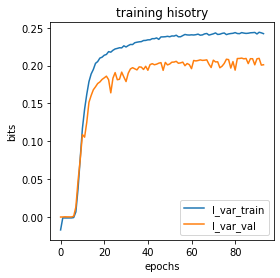

In [13]:
# Show training history
print('On test data:')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')

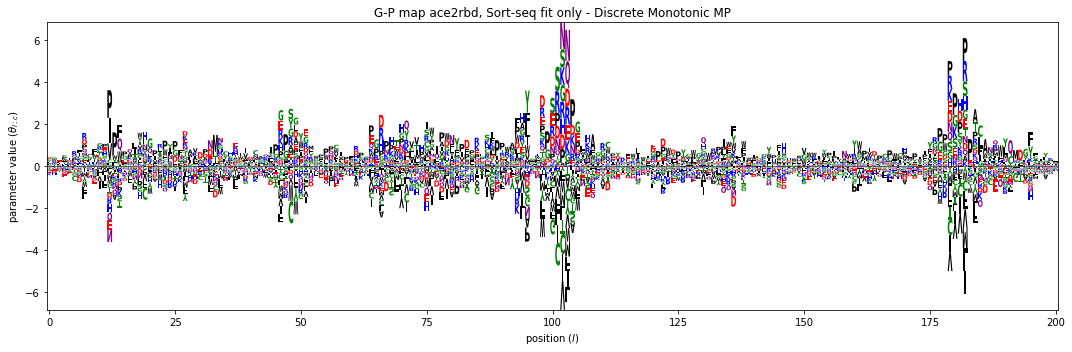

In [14]:
# Get G-P map parameters in matrix form
theta = np.squeeze(gpmap.weights[1].numpy())

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_mpa.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
#measurement_process = mp_mpa.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,1,figsize=[15,5])

# Left panel: draw logo using logomaker
ax = axs
logo = logomaker.Logo(-pd.DataFrame(theta,columns=model.alphabet), ax=ax,center_values=True, color_scheme='chemistry')
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map ace2rbd, Sort-seq fit only - Discrete Monotonic MP')

# Right panel: draw measurement process as heatmap
# ax = axs[1]
# im = ax.imshow(measurement_process,
#                cmap='Greens',
#                extent=phi_lim+y_lim,
#                vmin=0,
#                origin='lower',
#                interpolation='nearest',
#                aspect="auto")
# ax.set_yticks(y_all)
# ax.set_ylabel('bin number (y)')
# ax.set_xlabel('latent phenotype ($\phi$)')
# ax.set_title('measurement process')
# cb = plt.colorbar(im)
# cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout()
fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only.png',dpi=300,bbox_inches='tight')
plt.show()

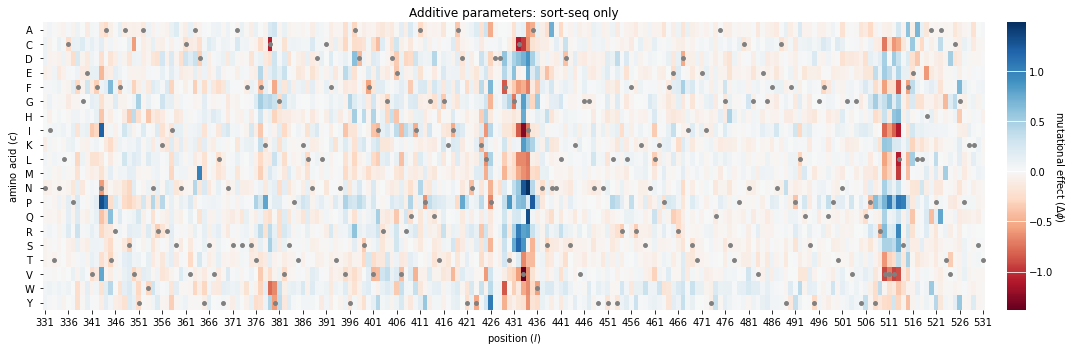

In [15]:
# Create figure
fig, ax = plt.subplots(1,1, figsize=(15,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=logo.df.values,
                                alphabet=alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':15},
                                cmap='RdBu',
                                cbar=True,
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'Additive parameters: sort-seq only')
heatmap_ax.set_xticks(np.arange(0,201,5))
heatmap_ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Adjust figure and show
fig.tight_layout(w_pad=5)
fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only_heatmap.png',dpi=300,bbox_inches='tight')

In [16]:
bloom_single_mut_df = pd.read_csv('single_mut_effects_Bloom.txt')
bloom_single_mut_df.head(10)

,site_RBD,site_SARS2,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg
0,1,331,N,A,N331A,N1A,-0.05,-0.02,-0.03,-0.14,-0.08,-0.11
1,1,331,N,C,N331C,N1C,-0.08,-0.10,-0.09,-1.56,-0.97,-1.26
2,1,331,N,D,N331D,N1D,0.00,0.07,0.03,-0.75,-0.12,-0.44
3,1,331,N,E,N331E,N1E,0.02,-0.02,0.00,-0.39,-0.24,-0.31
4,1,331,N,F,N331F,N1F,-0.03,-0.16,-0.10,-0.83,-0.57,-0.70
5,1,331,N,G,N331G,N1G,-0.06,-0.02,-0.04,-0.21,-0.29,-0.25
6,1,331,N,H,N331H,N1H,0.01,-0.05,-0.02,-0.86,-0.36,-0.61
7,1,331,N,I,N331I,N1I,-0.06,-0.08,-0.07,-1.05,-0.65,-0.85
8,1,331,N,K,N331K,N1K,-0.01,-0.01,-0.01,-0.17,-0.24,-0.20
9,1,331,N,L,N331L,N1L,-0.08,-0.01,-0.05,-0.81,-0.69,-0.75


In [31]:

bloom_exp_df = pd.DataFrame(columns=alphabet)
for site in range(1,201+1,):

    temp_df = bloom_single_mut_df[bloom_single_mut_df['site_RBD']==site].copy()
    temp_df['expr_lib1']
    bloom_exp_df.loc[site-1] = temp_df['expr_lib1'].values[0:20]




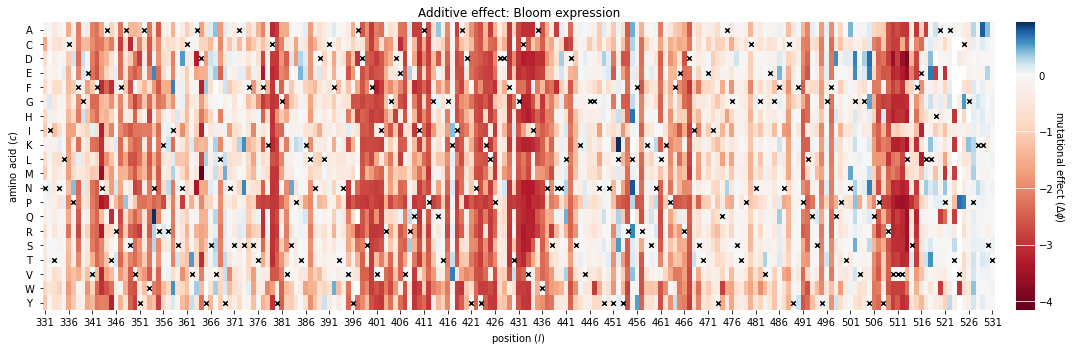

In [18]:
bloom_exp_df
# Create figure
fig, ax = plt.subplots(1,1, figsize=(15,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=bloom_exp_df.values,
                                alphabet=alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'black', 's':20,'marker':'x'},
                                cmap='RdBu',
                                cbar=True,
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'Additive effect: Bloom expression')

heatmap_ax.set_xticks(np.arange(0,201,5))
heatmap_ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Adjust figure and show
fig.tight_layout(w_pad=5)
#fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only_heatmap.png',dpi=300,bbox_inches='tight')

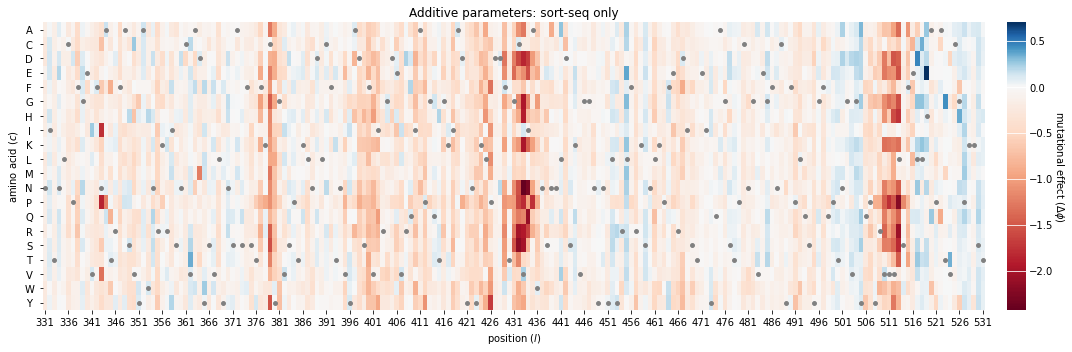

In [19]:
# Create figure
fig, ax = plt.subplots(1,1, figsize=(15,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=theta,
                                alphabet=alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':15},
                                cmap='RdBu',
                                cbar=True,
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'Additive parameters: sort-seq only')
heatmap_ax.set_xticks(np.arange(0,201,5))
heatmap_ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Adjust figure and show
fig.tight_layout(w_pad=5)
#fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only_heatmap.png',dpi=300,bbox_inches='tight')

In [20]:
theta_raw_df = pd.DataFrame(np.squeeze(gpmap.weights[1].numpy()),columns=alphabet)
theta_raw_df

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,-0.177384,-0.256994,-0.271294,-0.098713,-0.212119,-0.160569,-0.191414,-0.184303,-0.088237,-0.237378,-0.206349,-0.100825,-0.159105,-0.158713,-0.204530,-0.128602,-0.132410,-0.170634,-0.228021,-0.245898
1,0.013925,0.111406,0.128171,0.124566,0.041354,-0.021330,0.135783,0.037661,0.029200,0.078573,0.027069,0.135168,0.069096,0.104463,0.010314,0.086363,0.093713,0.075907,-0.005143,0.037561
2,-0.158215,-0.166679,-0.124525,-0.224754,-0.200031,-0.156404,-0.171281,-0.216346,-0.146767,-0.217071,-0.132014,-0.131886,-0.122244,-0.133678,-0.179452,-0.156762,-0.100321,-0.144391,-0.198034,-0.159434
3,0.081303,-0.044334,0.123514,0.206235,-0.017891,0.074005,0.021411,0.014155,0.050578,0.023078,0.103440,0.105016,-0.032960,0.141344,0.101005,0.092728,0.077181,0.052368,-0.030657,0.010704
4,-0.011623,-0.118323,-0.152950,-0.000643,-0.044715,-0.056513,-0.083020,-0.154832,-0.041903,-0.087472,-0.116227,-0.047855,-0.019159,-0.048579,-0.115036,-0.079304,-0.077340,-0.054320,-0.111138,-0.018946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.152713,0.014901,0.078423,0.125237,-0.019830,0.191809,0.123741,0.203419,0.133349,0.203502,0.242346,0.154442,0.073878,0.202341,0.103746,0.038792,0.024532,0.020408,0.096398,0.136657
197,0.044278,-0.016139,0.038047,0.050391,-0.015997,-0.009245,0.048302,-0.087410,0.016857,0.047601,0.051708,0.003986,-0.016955,0.101964,-0.001645,0.007592,0.049138,0.076971,0.063152,0.063687
198,0.101188,0.014363,-0.078449,-0.136637,-0.099214,-0.177058,-0.149217,-0.139041,-0.113650,-0.256357,-0.118117,-0.020015,-0.150527,-0.049698,-0.101022,-0.074842,-0.132915,-0.090027,-0.039205,-0.306761
199,0.113001,0.145139,0.142461,0.093211,0.059145,0.166890,0.090770,0.106758,0.026819,0.075237,0.030969,0.155633,0.161448,0.203548,0.106254,0.096497,0.070488,0.141684,0.138985,0.157067


In [21]:
# del bloom_exp_df['*']
# del theta_raw_df['*']

Text(0, 0.5, 'MAVE-NN2, G-P map')

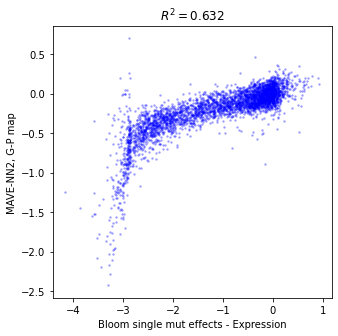

In [22]:
plt.figure(figsize=(5,5))
Rsq = np.corrcoef(bloom_exp_df.fillna(0).values.ravel(),theta_raw_df.fillna(0).values.ravel())[0,1]**2
#Rsq = np.corrcoef(bloom_exp_df.values, logo.df.values)[0,1]**2
#plt.scatter(theta_raw_df.values, -logo.df.values,s=5,alpha=0.25,color='red')
plt.scatter(bloom_exp_df.values, theta_raw_df.values,s=2.5,alpha=0.25,color='blue')

#lims = [-3,1]
#plt.plot(lims,lims,'--')
plt.xlabel('Bloom single mut effects - Expression')
plt.title(f'$R^2 = {Rsq:.3f}$')
plt.ylabel('MAVE-NN2, G-P map')

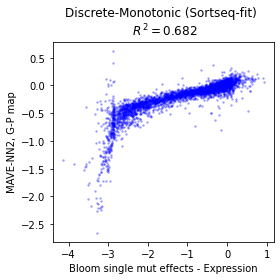

In [32]:
theta_lc = gpmap.get_theta(model,gauge='consensus')['theta_lc']
theta_lc_consensus_df = pd.DataFrame(theta_lc,columns=alphabet)

plt.figure(figsize=(4,4))
Rsq = np.corrcoef(bloom_exp_df.fillna(0).values.ravel(),theta_lc_consensus_df.fillna(0).values.ravel())[0,1]**2
#Rsq = np.corrcoef(bloom_exp_df.values, logo.df.values)[0,1]**2
#plt.scatter(theta_raw_df.values, -logo.df.values,s=5,alpha=0.25,color='red')
plt.scatter(bloom_exp_df.values.ravel(), theta_lc_consensus_df.values.ravel(),s=2.5,alpha=0.25,color='blue')

#lims = [-3,1]
#plt.plot(lims,lims,'--')
plt.xlabel('Bloom single mut effects - Expression')
plt.title(f'Discrete-Monotonic (Sortseq-fit) \n $R^2 = {Rsq:.3f}$')
plt.ylabel('MAVE-NN2, G-P map')
plt.tight_layout()
plt.savefig('mavenn_bloom_expression_comparison.png',dpi=200,bbox_inches='tight')

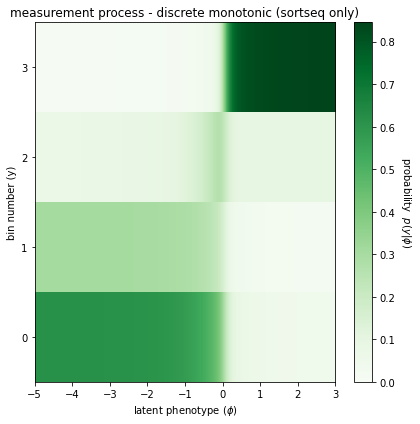

In [24]:
# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_mpa.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = mp_mpa.p_of_y_given_phi(y_all, phi_grid)


# Create figure with two panels
fig, ax = plt.subplots(1,1,figsize=[6,6])

# Right panel: draw measurement process as heatmap
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process - discrete monotonic (sortseq only)')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
fig.tight_layout()
fig.savefig('ace2rbd_mpa_measurment_prcoess_sortseq_only.png',dpi=300,bbox_inches='tight')


In [25]:
np.save('sortseq_gpmap_monotonic_agnostic',logo.df.values.ravel())
#np.save('sortseq_gpmap_discrete_agnostic',theta.ravel())